In [172]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from cap_functs import print_percents, print_percents_log
from nltk.stem import PorterStemmer
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KDTree
from sklearn.feature_extraction import stop_words


In [173]:
def rmse(y_pred, y_true):
    leng = len(y_pred)
    if leng == len(y_true):
        return np.sqrt((1/float(leng)) * np.sum((y_true-y_pred)**2))

def mae(y_pred, y_true):
    leng = len(y_pred)
    if leng == len(y_true):
        return (1/float(leng)) * np.sum(np.abs(y_true-y_pred))
    
def percent_within_x(y_pred, y_test, x):
    err_arr = 100.*(y_pred-y_test)/y_test
    tmp = []
    for num in err_arr:
        if np.abs(num) < x:
            tmp.append(num)
    return 100.*(len(tmp)/float(len(err_arr)))

def median_error(y_pred, y_test):
    err_arr = 100.*(y_pred-y_test)/y_test
    return np.median(np.abs(err_arr))

This notebook will used to extract the NLP data from airbnb listings, specifically, reviews of listings. 

In [3]:
# bnb_listings_sum = pd.read_csv('../ga_project_data/airbnb_data/listings_sum.csv')
# bnb_listings = pd.read_csv('../ga_project_data/airbnb_data/listings.csv')
bnb_reviews_sum = pd.read_csv('../ga_project_data/airbnb_data/reviews_sum.csv')
bnb_reviews = pd.read_csv('../ga_project_data/airbnb_data/reviews.csv')

In [4]:
bnb_list_test = pd.read_pickle('bnb_list_test')
bnb_list_test

,id,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,amenities,price,...,Street Defects_cnt,Sidewalk or Curb_cnt,Color Curb_cnt,graffiti_cnt,park_reg_pts,ldn_76,ldn_74,ldn_72,ldn_70,ldn_66
7207,11826847,2.0,37.790072,-122.415288,2,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",69.0,...,47,79,7,927,20,275,300,302,306,272
2301,7065694,1.0,37.738057,-122.506229,5,1.0,2.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",350.0,...,25,8,0,76,184,0,0,0,128,340
3216,5444754,5.0,37.758121,-122.418073,2,1.5,1.0,1.0,"{Internet,Kitchen,""Elevator in Building"",Heati...",105.0,...,31,153,13,4482,52,19,68,135,177,265
5006,12151345,4.0,37.780958,-122.389284,4,1.5,1.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",249.0,...,28,6,2,77,0,155,129,129,104,184
3749,5616609,1.0,37.740353,-122.453188,2,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",""Air Conditio...",119.0,...,8,6,0,0,198,0,0,0,6,166
5220,7902889,2.0,37.785940,-122.394088,1,1.0,1.0,2.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Elev...",90.0,...,52,31,4,158,4,279,235,208,199,197
6461,1768861,3.0,37.753174,-122.443759,4,2.0,2.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",599.0,...,44,34,3,150,294,12,157,235,288,341
1618,5632275,1.0,37.754373,-122.429536,2,1.0,1.0,1.0,"{TV,""Wireless Internet"",Kitchen,""Pets Allowed""...",165.0,...,22,18,17,58,0,0,0,57,276,331
3389,4106442,1.0,37.754515,-122.416497,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",200.0,...,54,76,7,1719,50,139,186,211,227,210
3418,1269738,1.0,37.760553,-122.420868,3,1.0,2.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",120.0,...,41,164,12,9263,83,0,35,120,122,209


In [5]:
bnb_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,8308113,47419975,2015-09-18,6288054,Colin,Host was excellent and was contactable / respo...
1,3320213,14805088,2014-06-26,17101713,Faye,The place was clean and spacious and the guy t...
2,3320213,17192435,2014-08-08,182792,Jocelyne & Pontus,This place wasn't as pleasant as we hoped. Had...
3,3320213,17597907,2014-08-14,19649465,Francesco,Si tratta di una piccola pensione/albergo.\nSt...
4,3320213,18293826,2014-08-24,1104165,Daniel,"Nice room, cool neighbourhood. Note that this ..."


In [6]:
bnb_reviews['comments'] = bnb_reviews.comments.apply(lambda x: str(x))
reviews = bnb_reviews.groupby('listing_id')[['comments']].apply(lambda x: x.sum())
reviews.reset_index(inplace=True)

It appears there are many dozens of reviews that were automatically generated when hosts cancelled reservations. They are meant to be a penalty, discouraging people from cancelling - penalties are steeper within 7 days of a reservation.

At first I thought the entries should be eliminated, but I am going to keep them considering they may be a predictor of prices if captured in the tfidf vectors.

In [7]:
host_cancel = reviews[reviews.comments.str.startswith(r'The host canceled this reservation')].listing_id
host_cancel.shape

(222,)

In [8]:
reviews.head(8)

,listing_id,comments
0,958,"Our experience was, without a doubt, a five st..."
1,5193,This Nob Hill San Francisco studio is immacula...
2,5841,Steve was a wonderful host. He provided loads ...
3,5858,We had a fabulous time staying with Philip and...
4,7918,My stay was fantastic! The neighborhood is gr...
5,8014,It was a really good experience because I've j...
6,8142,"Excellent! The space is clean and quiet, and t..."
7,8339,My stay was wonderful in many ways; the apartm...


Before merging with residuals for modeling, the comments will be tfidf vectorized. The listings in the model are likely to change given the parameters of the model (in another notebook), so it's best to calculate the vectors for all reviews before merging with the other data.

In [9]:
def clean_text(string):
    tmp = re.sub(r'<[\w/:;"=. ?!_,#@+~%&-]+>', '', string)
    tmp = re.sub(r'[( ]?https?://[0-9A-Za-z/:;"=.?!_,#@+~%&\-]+[ )]?', ' ', tmp, re.UNICODE)
    tmp = re.sub(r"\n", r" ", tmp, re.UNICODE)
    tmp = re.sub(r"\t", r" ", tmp, re.UNICODE)
    tmp = re.sub(r"\r", r" ", tmp, re.UNICODE)
    tmp = re.sub(r"[0-9.]+[thrdst]{0,2}", r" ", tmp, re.UNICODE)
    tmp = re.sub(r"\r\n\r\n", r" ", tmp, re.UNICODE)
    tmp = re.sub(r"\r\n", r" ", tmp, re.UNICODE)
    tmp = re.sub(r"\.\.\.", r" ", tmp, re.UNICODE)
    tmp = re.sub(r"\!+", r" ", tmp)
    tmp = re.sub(r'\"', r"", tmp)
    tmp = re.sub(r"\'", r"", tmp)
    tmp = re.sub(r"\-", r"", tmp)
    tmp = re.sub(r'[$%?&,.\;:()/+]', r"", tmp)
    tmp = re.sub(r"00", r"", tmp)
    tmp = re.sub(r"10", r"", tmp)
    tmp = re.sub(r"15", r"", tmp)
    tmp = re.sub(r"20", r"", tmp)
    tmp = re.sub(r"30", r"", tmp)
    tmp = re.sub(r"100", r"", tmp)
    tmp = re.sub(r"minute[s]", r"", tmp)
    return tmp.lower()
# test = reviews.loc[2, 'comments']
# clean_text(test)


In [10]:
test = reviews.loc[3, 'comments']
clean_text(test)

'we had a fabulous time staying with philip and tania  they were the most generous and relaxed hosts we could have hoped for and full of local knowledge and recommendations  the house itself is beautifully decorated in an arty eclectic style that refelcts the personality of this great couple  much better than any conventional bb or hostel  it really made our trip more memorable and special and wed certainly stay with them again if we ever go back to sf great place to stay in sf  tania and philip were very welcoming  they gave us good advice on sf musts  donts  the house is spacious with a lot of natural light coming in  it is situated near a bart stop which brings you easily downtown or to the airport  i will definitively stay there if i go back to sf we had an excellent stay  we loved the neighbourhood the tasteful interior and above all the kind and cheerful hosts  philip and tania have been very flexible in having us with a    year old were helpful in advising us around san francisc

In [11]:
reviews['comments'] = reviews.comments.apply(lambda x: clean_text(x))
my_stop_words = list(stop_words.ENGLISH_STOP_WORDS)

my_stop_words += "im"
my_stop_words += "id"
my_stop_words += "00"
my_stop_words += "10"
my_stop_words += "15"
my_stop_words += "12"
my_stop_words += "20"
my_stop_words += "30"
my_stop_words += "100"
my_stop_words += "minutes"
my_stop_words += "minute"

In [12]:
# from nltk import tokenize
# def sentiment_eval(string):
# #    lines_list = tokenize.sent_tokenize(string)
#     sid = SentimentIntensityAnalyzer()
#     ss = sid.polarity_scores(string)
#     return ss.values()

In [13]:
sent_arr = np.array([[0,0,0,0]])
for line in reviews.comments.values:
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(line)
    sent_arr = np.append(sent_arr, np.array(ss.values()))

sent_arr.reshape(-1, 4)[1:, :]

array([[ 0.027,  0.679,  0.295,  1.   ],
       [ 0.024,  0.664,  0.312,  1.   ],
       [ 0.03 ,  0.675,  0.295,  1.   ],
       ..., 
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.017,  0.747,  0.235,  0.986],
       [ 0.   ,  1.   ,  0.   ,  0.   ]])

In [14]:
revs_sents = pd.DataFrame(sent_arr.reshape(-1, 4)[1:,:], columns=ss.keys())
revs_sents.head()

,neg,neu,pos,compound
0,0.027,0.679,0.295,1.0000
1,0.024,0.664,0.312,1.0000
2,0.030,0.675,0.295,1.0000
3,0.012,0.619,0.369,1.0000
4,0.049,0.682,0.269,0.9996


In [15]:
reviews_mod = pd.concat([reviews, revs_sents], axis=1)
reviews_mod.head()

,listing_id,comments,neg,neu,pos,compound
0,958,our experience was without a doubt a five star...,0.027,0.679,0.295,1.0000
1,5193,this nob hill san francisco studio is immacula...,0.024,0.664,0.312,1.0000
2,5841,steve was a wonderful host he provided loads ...,0.030,0.675,0.295,1.0000
3,5858,we had a fabulous time staying with philip and...,0.012,0.619,0.369,1.0000
4,7918,my stay was fantastic the neighborhood is gr...,0.049,0.682,0.269,0.9996


In [16]:
reviews_mod = reviews_mod.groupby('listing_id')[['neg','neu','pos','compound']].mean()
reviews_mod.reset_index(inplace=True)

In [17]:
pd.to_pickle(reviews_mod, 'review_sentiments')
reviews_mod

,listing_id,neg,neu,pos,compound
0,958,0.027,0.679,0.295,1.0000
1,5193,0.024,0.664,0.312,1.0000
2,5841,0.030,0.675,0.295,1.0000
3,5858,0.012,0.619,0.369,1.0000
4,7918,0.049,0.682,0.269,0.9996
5,8014,0.024,0.698,0.278,1.0000
6,8142,0.049,0.691,0.260,0.9969
7,8339,0.021,0.649,0.330,1.0000
8,8739,0.014,0.618,0.368,1.0000
9,8775,0.018,0.764,0.218,0.9998


In [18]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems


In [19]:
tfidf = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), 
                        max_df=0.55, min_df=0.25, stop_words=my_stop_words) # adjust max/min df?
voc_spar = tfidf.fit_transform(reviews.comments.values)
voc_spar

# c_vec = CountVectorizer(strip_accents='unicode', ngram_range=(1,2), 
#                         max_df=0.7, min_df=0.1, stop_words='english') # adjust max/min df?
# c_spar = c_vec.fit_transform(reviews.comments.values)
# c_spar

<6396x241 sparse matrix of type '<type 'numpy.float64'>'
	with 561671 stored elements in Compressed Sparse Row format>

In [20]:
voc_spar

<6396x241 sparse matrix of type '<type 'numpy.float64'>'
	with 561671 stored elements in Compressed Sparse Row format>

In [21]:
comments_tfidf = pd.DataFrame(voc_spar.todense(), columns=tfidf.get_feature_names())
comments_tfidf = pd.concat([reviews['listing_id'], comments_tfidf], axis=1)
comments_tfidf = comments_tfidf.merge(reviews_mod, on='listing_id', how='left')
# comments_c_vec = pd.DataFrame(c_spar.todense(), columns=c_vec.get_feature_names())
# comments_c_vec = pd.concat([reviews['listing_id'], comments_c_vec], axis=1)

comments_tfidf.iloc[0:100]

,listing_id,able,absolutely,access,accommodating,accurate,airbnb,airbnb experience,amazing,amenities,...,welcoming,went,wifi,work,worked,youre,neg,neu,pos,compound
0,958,0.015324,0.046690,0.072350,0.013397,0.000000,0.080592,0.000000,0.038261,0.033421,...,0.040799,0.048412,0.035728,0.030711,0.018414,0.000000,0.027,0.679,0.295,1.0000
1,5193,0.060574,0.049215,0.085796,0.010591,0.037164,0.063713,0.014978,0.141155,0.052843,...,0.026878,0.057409,0.063551,0.030349,0.036394,0.027040,0.024,0.664,0.312,1.0000
2,5841,0.000000,0.024325,0.022616,0.062818,0.000000,0.062980,0.059223,0.039866,0.026118,...,0.021256,0.000000,0.000000,0.048000,0.000000,0.133645,0.030,0.675,0.295,1.0000
3,5858,0.023979,0.036531,0.011321,0.062893,0.000000,0.115602,0.088941,0.069849,0.000000,...,0.159607,0.025252,0.013977,0.024029,0.000000,0.000000,0.012,0.619,0.369,1.0000
4,7918,0.067174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073252,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049,0.682,0.269,0.9996
5,8014,0.036283,0.000000,0.000000,0.015860,0.000000,0.079506,0.000000,0.030196,0.000000,...,0.032199,0.095519,0.042296,0.018179,0.021799,0.000000,0.024,0.698,0.278,1.0000
6,8142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049,0.691,0.260,0.9969
7,8339,0.102440,0.104039,0.024183,0.022390,0.031425,0.000000,0.000000,0.213140,0.055854,...,0.068184,0.026969,0.000000,0.000000,0.000000,0.000000,0.021,0.649,0.330,1.0000
8,8739,0.027078,0.060002,0.044165,0.055956,0.003021,0.105727,0.051739,0.081948,0.013422,...,0.113601,0.033699,0.005739,0.012334,0.008874,0.010989,0.014,0.618,0.368,1.0000
9,8775,0.092632,0.000000,0.131204,0.000000,0.000000,0.000000,0.000000,0.038546,0.000000,...,0.000000,0.000000,0.000000,0.046411,0.000000,0.000000,0.018,0.764,0.218,0.9998


In [24]:
comments_tfidf.columns.tolist()

['listing_id',
 u'able',
 u'absolutely',
 u'access',
 u'accommodating',
 u'accurate',
 u'airbnb',
 u'airbnb experience',
 u'amazing',
 u'amenities',
 u'apartment clean',
 u'apartment great',
 u'appreciated',
 u'arrival',
 u'arrived',
 u'available',
 u'away',
 u'awesome',
 u'bars',
 u'bart',
 u'bathroom',
 u'bed',
 u'bed comfortable',
 u'bedroom',
 u'best',
 u'better',
 u'big',
 u'bit',
 u'block',
 u'blocks',
 u'book',
 u'breakfast',
 u'bus',
 u'cafes',
 u'came',
 u'car',
 u'central',
 u'check',
 u'checkin',
 u'clean comfortable',
 u'coffee',
 u'come',
 u'comfy',
 u'communication',
 u'convenient',
 u'cool',
 u'couple',
 u'cozy',
 u'cute',
 u'day',
 u'days',
 u'decorated',
 u'definitely recommend',
 u'definitely stay',
 u'described',
 u'description',
 u'did',
 u'didnt',
 u'distance',
 u'district',
 u'dont',
 u'door',
 u'downtown',
 u'early',
 u'easily',
 u'easy access',
 u'eat',
 u'enjoy',
 u'enjoyed',
 u'enjoyed stay',
 u'equipped',
 u'especially',
 u'exactly',
 u'exactly described',
 u

In [25]:
pd.to_pickle(comments_tfidf, 'comments_tfidf')

Merge with test set from chosen model.

In [187]:
X_train_orig = pd.read_pickle('X_train')
y_train_orig = pd.read_pickle('y_train')
X_test_orig = pd.read_pickle('X_test')
y_test_orig = pd.read_pickle('y_test')
y_pred_orig = pd.read_pickle('y_pred')
idx_id = pd.DataFrame(pd.read_pickle('idx_id'))

xtest_cols = list(X_test_orig.columns.values)

In [188]:
y_pred_orig.shape

(2075,)

In [189]:
com_tfidf_mod = idx_id.merge(comments_tfidf, how='left', left_on='id', right_on='listing_id')
X_test_mod = X_test_orig.merge(com_tfidf_mod, how='left', left_index=True, right_index=True, suffixes=('', '_y'))


host_total_listings_count           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_scores_cleanliness           0
review_scores_checkin               0
review_scores_communication         0
review_scores_location              0
review_scores_value                 0
calculated_host_listings_count      0
reviews_per_month                   0
entire_home_apt                     0
private_room                        0
shared_room                         0
apartment   

In [193]:
X_ctf = X_test_mod.drop(xtest_cols+['listing_id', 'id_x'], axis=1)
X_ctf = X_ctf.fillna(X_test_mod.mean())
# for col in X_ctf.columns.values:
#     X_ctf[col].fillna(, inplace=True)
# print X_ctf.shape
X_ctf.head()

,able,absolutely,access,accommodating,accurate,airbnb,airbnb experience,amazing,amenities,apartment clean,...,welcoming,went,wifi,work,worked,youre,neg,neu,pos,compound
2778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.077118,0.091507,0.000000,0.000000,0.000000,0.000000,0.021000,0.69500,0.284000,0.999500
7107,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354
7072,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354
5481,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354
573,0.138747,0.010839,0.020156,0.037324,0.026192,0.102905,0.013195,0.035530,0.011639,0.012632,...,0.037887,0.022478,0.111975,0.032084,0.025650,0.059554,0.028000,0.69900,0.273000,1.000000


Create an array of y_test-y_pred residuals.

In [180]:
resids_log = y_test_orig-y_pred_orig
resids = np.expm1(y_test_orig)-np.expm1(y_pred_orig)
per_resid = (np.expm1(y_test_orig)-np.expm1(y_pred_orig))/np.expm1(y_test_orig)
resids.shape

(2075,)

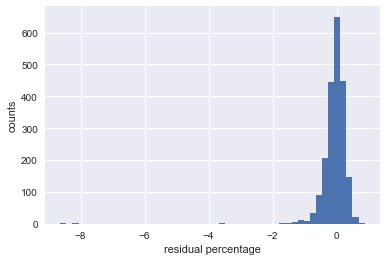

In [181]:
plt.hist(per_resid, bins=50)
plt.xlabel('residual percentage')
plt.ylabel('counts');

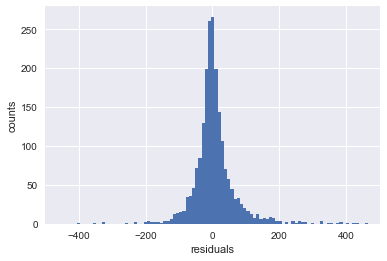

In [182]:
plt.hist(resids, bins=200)
plt.xlabel('residuals')
plt.ylabel('counts')
plt.xlim((-500, 500));

In [183]:
resid_mod = pd.DataFrame(X_test_orig)
resid_mod['resids'] = resids
resid_mod = resid_mod[['resids']]
resid_mod = resid_mod.merge(bnb_list_test, how='left', left_index=True, right_index=True)
resid_mod = resid_mod[['latitude', 'longitude', 'resids']]
resid_mod.to_csv('residuals_mod.txt', index=None)

In [196]:
X_test_mod.fillna(X_test_mod.mean(), inplace=True)
X_test_mod.isnull().sum()

host_total_listings_count         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
guests_included                   0
extra_people                      0
minimum_nights                    0
maximum_nights                    0
availability_30                   0
availability_60                   0
availability_90                   0
availability_365                  0
number_of_reviews                 0
review_scores_rating              0
review_scores_accuracy            0
review_scores_cleanliness         0
review_scores_checkin             0
review_scores_communication       0
review_scores_location            0
review_scores_value               0
calculated_host_listings_count    0
reviews_per_month                 0
entire_home_apt                   0
private_room                      0
shared_room                       0
apartment                         0
bed_breakfast               

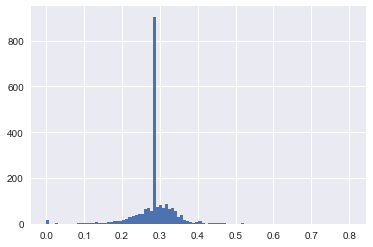

In [199]:
plt.hist(X_test_mod.pos, bins=100);

In [198]:
X_ctf

,able,absolutely,access,accommodating,accurate,airbnb,airbnb experience,amazing,amenities,apartment clean,...,welcoming,went,wifi,work,worked,youre,neg,neu,pos,compound
2778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.077118,0.091507,0.000000,0.000000,0.000000,0.000000,0.021000,0.69500,0.284000,0.999500
7107,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354
7072,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354
5481,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354
573,0.138747,0.010839,0.020156,0.037324,0.026192,0.102905,0.013195,0.035530,0.011639,0.012632,...,0.037887,0.022478,0.111975,0.032084,0.025650,0.059554,0.028000,0.69900,0.273000,1.000000
5119,0.000000,0.000000,0.159561,0.073866,0.000000,0.074057,0.000000,0.000000,0.000000,0.099995,...,0.074981,0.000000,0.000000,0.000000,0.101526,0.000000,0.049000,0.71900,0.232000,0.999500
8411,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354
1649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.61700,0.358000,0.981900
732,0.036974,0.037551,0.000000,0.129301,0.000000,0.064818,0.000000,0.061544,0.000000,0.043760,...,0.032813,0.038936,0.043102,0.074100,0.044430,0.041263,0.008000,0.71700,0.275000,0.999900
6645,0.028810,0.030125,0.035990,0.047838,0.017244,0.050844,0.014806,0.061826,0.024542,0.023420,...,0.057219,0.024247,0.021332,0.032757,0.016775,0.022783,0.019962,0.69315,0.286868,0.964354


In [200]:
# ss = StandardScaler()
# mms = MinMaxScaler()
# X_ctf_m = mms.fit_transform(X_ctf)
# X_ctf_s = ss.fit_transform(X_ctf)

#X_train, X_test, y_train, y_test = train_test_split(X_ctf, resids, test_size=0.3, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X_test_mod, X, test_size=0.4, random_state=2)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_ctf, y_pred_orig, test_size=0.4, random_state=2)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_ctf, y_test_orig, test_size=0.4, random_state=2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmse(y_pred, y_test)
print mae(y_pred, y_test)
linreg.score(X_test, y_test)


94.3477713044
60.4792952397


-0.45106854003124863

In [201]:
alphas_ = (0.0001, 0.001, 0.01, 0.1, 1., 10., 50., 100., 200., 250.,
                   300., 350., 500., 1000., 10000., 12000., 100000.)

ridge = RidgeCV(cv=10, alphas=alphas_)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
#print mae(np.expm1(y_pred), np.expm1(y_test))
ridge.score(X_test, y_test)

78.3970102492    8.8542086179


-0.0018982928631705585

In [202]:
##print_percents(np.expm1(y_test_o)-y_pred, np.expm1(y_test_t))
print_percents(y_pred, y_test)
#print_percents_log(y_pred, y_test)

Percent within 5 of price:   0.241
Percent within 10 of price:  0.602
Percent within 20 of price:  1.928

Median error (percent):      107.689



/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in expm1
  if __name__ == '__main__':


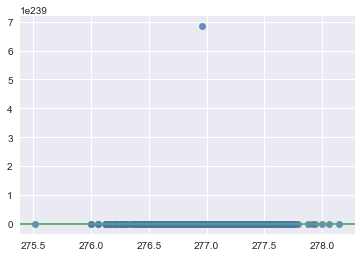

In [203]:
sns.regplot(np.expm1(y_pred), np.expm1(y_test))
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((-200, 200))
# plt.ylim((-200, 200));

In [204]:
params = {'alpha':(0.001, 0.01, 0.1, 1., 10., 50., 100., 200., 250.,
                   300., 350., 500., 1000., 10000., 12000., 100000.)}

ridge = Ridge()
gs_ridg = GridSearchCV(ridge, params, verbose=1)
gs_ridg.fit(X_train, y_train)
gs_ridg.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.5s finished


{'alpha': 50.0}

In [205]:
alphas_ = (0.01, .1, 1, 10, 100, 1000, 10000., 100000.)

lass_cv = LassoCV()
lass_cv.fit(X_train, y_train)
y_pred = lass_cv.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
lass_cv.score(X_test, y_test)

/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


78.3970419141    8.85421040602
43.6558773814


-0.0018991022053953532

In [206]:
xgb = XGBRegressor(n_estimators=300)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
xgb.score(X_test, y_test)

81.3550416209    9.01970296744
47.4193898009


-0.078930768588991729

In [207]:
print_percents(y_pred, y_test)
#print_percents_log(y_pred, y_test)

Percent within 5 of price:   2.169
Percent within 10 of price:  3.012
Percent within 20 of price:  5.301

Median error (percent):      112.074



/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in expm1
  if __name__ == '__main__':


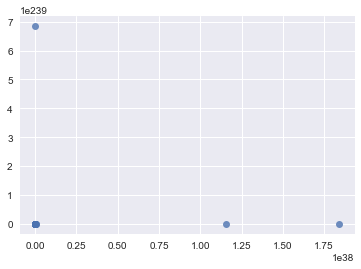

In [208]:
sns.regplot(np.expm1(y_pred), np.expm1(y_test))
plt.plot(range(0,2000), range(0,2000))
# plt.xlim((-100,100))
# plt.ylim((-100,100));

In [209]:
rfr = RandomForestRegressor(n_estimators=300, n_jobs=4)#min_samples_split=2, min_samples_leaf=1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print rmse(y_pred, y_test), '  ', np.sqrt(rmse(y_pred, y_test))
print mae(y_pred, y_test)
rfr.score(X_test, y_test)

82.1468666754    9.06349086586
46.2996249295


-0.10003534794081537

In [212]:
print_percents(y_pred, y_test)
#print_percents_log(y_pred, y_test)

Percent within 5 of price:   1.084
Percent within 10 of price:  1.928
Percent within 20 of price:  4.940

Median error (percent):      107.428



/Users/taylorkilian/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in expm1
  if __name__ == '__main__':


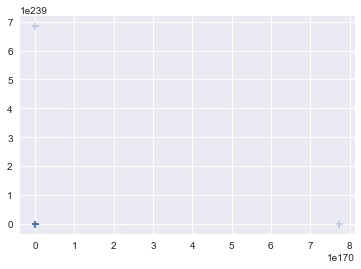

In [213]:
sns.regplot(np.expm1(y_pred), np.expm1(y_test), marker='+', scatter_kws={'alpha':0.3})
#sns.regplot(y_pred, y_test)
plt.plot(range(0,500), range(0,500))
# plt.xlim((-100,100))
# plt.ylim((-100,100));

In [9]:
# Not related to the content of this notebook...will move to another notebook or...
# ...expand this notebook to include the image processing
# Used to retrieve images from urls in the table and store them locally in the directory listed

# from urllib import urlretrieve

# print bnb_listings.picture_url.nunique()
# id_and_url = zip(bnb_listings.id.values, bnb_listings.picture_url.values)

# for i, u in id_and_url:
#     urlretrieve(u, '../ga_project_data/listing_images/{0}.jpg'.format(i))